# Iterative self-consistent approach to the committor function

- Optimization based on a variational principle
- We alternate cycles of training and sampling

In [1]:
# general libs
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# mlcolvar modules
from mlcolvar.utils.plot import paletteFessa
from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential, muller_brown_mfep

# useful stuff
torch.set_default_dtype(torch.float64)
mfep = muller_brown_mfep()
reference_committor_model = torch.jit.load('./model_committor_reference.pt').to(torch.float64).to(torch.device('cpu'))


def convert_model(model_name, n_input):
    loaded_model = torch.jit.load(model_name).to(torch.device('cpu')).to(torch.float32)
    fake_input = torch.rand(n_input).to(torch.float32)
    loaded_model(fake_input)
    frozen_model = torch.jit.trace(loaded_model, fake_input)
    torch.jit.save(frozen_model, model_name)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize general variables

In [2]:
from mlcolvar.cvs.committor.utils import initialize_committor_masses

# temperature
T = 1 
# Boltzmann factor in the RIGHT ENREGY UNITS!
kb = 1
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

# this helper function initializes the masses array with the right shape already, it's more useful for real systems :)
atomic_masses = initialize_committor_masses(atom_types=[0], masses=[1], n_dims=2)

Beta: 1.0 
1/beta: 1.0


# Iteration 0: unbiased data only
At this stage, our committor guess will not be much more than a classifier as we only have access to unbiased data from the metastable states!

### Load data

In [4]:
from mlcolvar.data import DictDataset,DictModule
from mlcolvar.core.nn.utils import Custom_Sigmoid
from mlcolvar.utils.io import load_dataframe,create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights

folder = "../1_enhanced_sampling/simulations/unbiased_sims"
filenames = ["A/COLVAR", 
             "B/COLVAR"]

# we generate the dataset for the training 
dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               folder=folder,
                                               create_labels = True,
                                               filter_args={'regex': 'p.x|p.y'},
                                               return_dataframe=True,
                                               stop = 8000,
                                               stride=4)

# we are using unbiased simulations
bias = torch.zeros(len(dataset))

# we need to compute the weights to be used in the variational principle 
dataset = compute_committor_weights(dataset=dataset,
                                    bias=bias,
                                    data_groups=[0, 1],
                                    beta=beta)

# we can use a single batch and no validation set for the training
datamodule = DictModule(dataset=dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 17)
Class 1 dataframe shape:  (2000, 17)

 - Loaded dataframe (4000, 17): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels']
 - Descriptors (4000, 2): ['p.x', 'p.y']


#### Initialize model

In [5]:
from mlcolvar.cvs import Committor

# setup lr scheduler for lr decay
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# define model options
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 }}

# initialize model
model = Committor(layers=[2, 20, 20, 1],
                  mass=atomic_masses,
                  alpha=10,
                  delta_f=0,
                  options=options)

#### Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 501    | [1, 2]   | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | [1, 1]   | [1, 1]   
------------------------------------------------------------------
501       Trainable params
0         Non-trainable params
501       Total params
0.002     Total estimated model params size (MB)
/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you w

Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 141.27it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 115.97it/s, v_num=5]


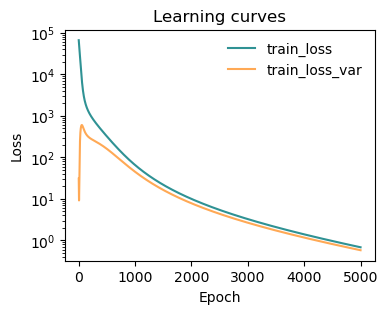

In [6]:
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics

# define callbacks for the training
metrics = MetricsCallback()

# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000
trainer = lightning.Trainer(callbacks=[metrics], 
                            max_epochs=5000, 
                            logger=None, 
                            enable_checkpointing=False,
                            limit_val_batches=0, 
                            num_sanity_val_steps=0)

# fit model on our datamodule
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics=metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log',
                  ax=ax)

#### Visualize results

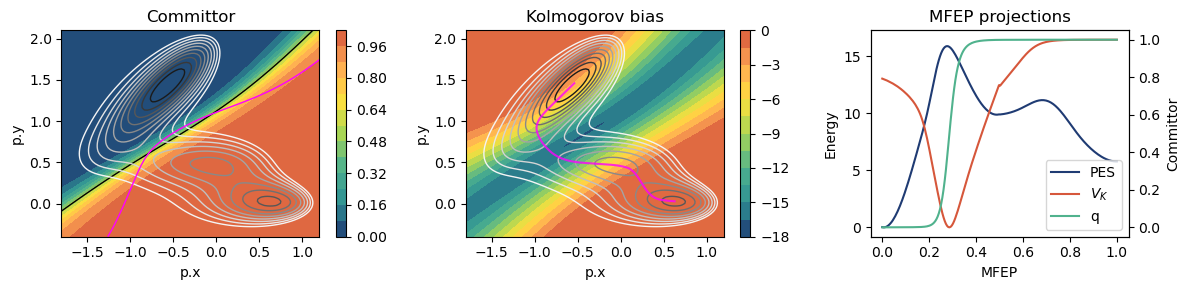

In [27]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

# initialize Kolmogorov bias computation
bias_model = KolmogorovBias(model, beta=beta)

# compute quantities on mfep
pes_mfep = muller_brown_potential(mfep[:, 0], mfep[:, 1])
bias_mfep = bias_model(torch.Tensor([mfep]).squeeze(0))
with torch.no_grad():
    q_mfep = model(torch.Tensor([mfep]).squeeze(0))

# plot stuff
fig, axs = plt.subplots(1,3,figsize=(12,3), gridspec_kw={"width_ratios" : [5,5,4]})

# plot committor
ax = axs[0]
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plot_isolines_2D(reference_committor_model, ax=ax, levels=[0.5], mode='contour', linewidths=1, cmap='spring')
ax.set_title('Committor')
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

# plot Kolmogorov bias
ax = axs[1]
plot_isolines_2D(bias_model, ax=ax, colorbar=True, allow_grad=True)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
ax.plot(mfep[:, 0], mfep[:, 1], color='magenta', alpha=0.8)
ax.set_title('Kolmogorov bias')
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

# plot projections on the minimum free energy path (MFEP)
ax = axs[2]
pes  = ax.plot(np.linspace(0,1,200), pes_mfep, c=paletteFessa[0], label='PES')
bias = ax.plot(np.linspace(0,1,200), bias_mfep - bias_mfep.min(), c=paletteFessa[6], label='$V_K$')

ax2 = ax.twinx()
q = ax2.plot(np.linspace(0,1,200), q_mfep, c=paletteFessa[2], label='q')

lns = pes+bias+q
labs = [l.get_label() for l in lns]

ax.legend(lns, labs, loc=0)
ax.set_title('MFEP projections')
ax.set_xlabel('MFEP')
ax.set_ylabel('Energy')
ax2.set_ylabel('Committor')

plt.tight_layout()
plt.show()

#### Export trained model to torchscript

In [29]:
# number of iteration
iter = 0

# export q model
model.to_torchscript(f'models/model_{iter}_q.pt', method='trace')

# this ensures everything is on the right device and with the right dtype
convert_model(f'models/model_{iter}_q.pt', 2)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/torch/jit/_trace.py:753: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


#### Run plumed simulations

In [32]:
RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')

folder iter_0


generate_and_run_sims.sh: line 40: wait: pid 1 is not a child of this shell


CompletedProcess(args='cd biased_sims && bash generate_and_run_sims.sh 0', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

#### Visualize sampling

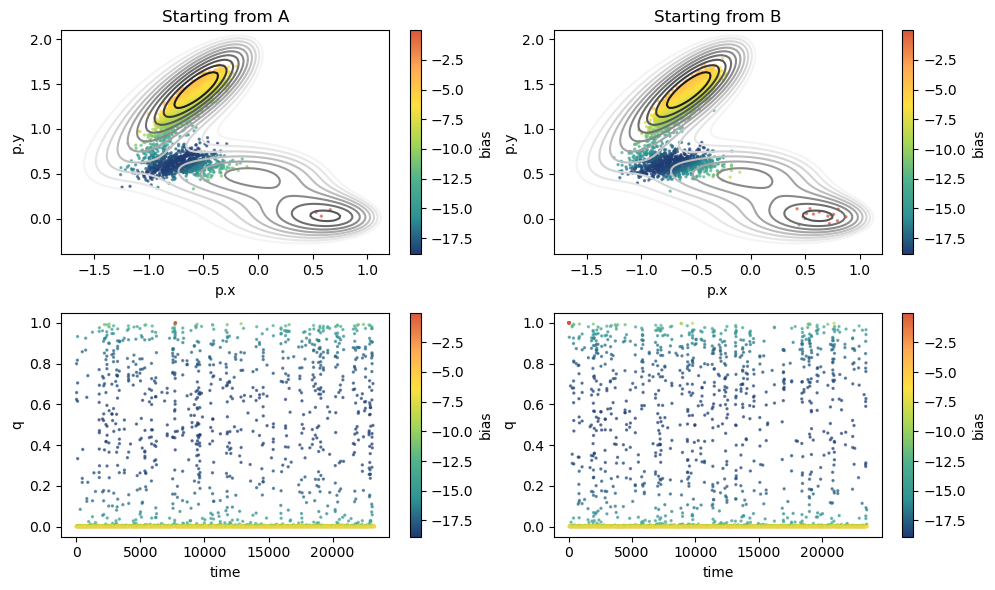

In [70]:
sampling = load_dataframe([f'biased_sims/iter_{iter}/A/COLVAR', f'biased_sims/iter_{iter}/B/COLVAR'], start=0)
fig, axs = plt.subplots(2,2,figsize=(10,6))

for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    cp = ax.scatter(temp['p.x'], temp['p.y'], c=temp['bias'], cmap='fessa',s=2, alpha=0.6)
    ax.set_xlabel('p.x')
    ax.set_ylabel('p.y')
    ax.set_title(f'Starting from {s}')
    cbar = plt.colorbar(cp, ax=ax, label = 'bias')
    cbar.solids.set(alpha=1)


    ax = axs[1, i]
    ax.scatter(temp['time'], temp['q.node-0'], c=temp['bias'], cmap='fessa',s=2, alpha=0.6)
    ax.set_xlabel('time')
    ax.set_ylabel('q')
    cbar = plt.colorbar(cp, ax=ax, label = 'bias')
    cbar.solids.set(alpha=1)

    

plt.tight_layout()
plt.show()